<a href="https://colab.research.google.com/github/soutrik71/MInMaxBERT/blob/main/notebook/BertTextClassifier_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this notebook is to test out Simple and Complex Questions using a Base Bert Model:
* Focus on Tokenization part for the data
* Focus on model pre-training in pytorch
* Application of Focal loss in handling imbalanced data
* Application of adding weights to loss function for imbalanced class
* Evaluation Framework
* More homogenous and representative data

In [103]:
!pip install transformers datasets torcheval --upgrade --quiet
!pip install -U sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 955.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torcheval.metrics import BinaryAccuracy,BinaryF1Score,BinaryPrecision,BinaryRecall,BinaryConfusionMatrix
from tqdm import tqdm
import warnings, os, random
from torchsummary import summary
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [4]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [5]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print , path="baseline.pt"):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Loading from git repo

In [7]:
df1 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/classifier_data.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/maz_abiconnect_curated_question_list.csv")
df3  = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/cpna_curated_list.csv")
df4 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/finance_questions_list.csv")

In [8]:
final_df = pd.concat([df1, df2,df3], ignore_index=True)

In [9]:
final_df.head()

,Domain,Question,FinalLabel
0,logistics,What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?,Simple
1,logistics,what should beThe target average time in route (Depot to Depot),Simple
2,marketing_abi_connect,Which social media platform has the highest number of negative sentiments followed by male population for the above brands?,Simple
3,logistics,What Are Tools And Equipment Used In Truck Departure Process?,Simple
4,maz_commercial,"What is the net revenue per HL in Aug 2023, July 2023 and percentage change from July to Aug for the above brand?",Simple


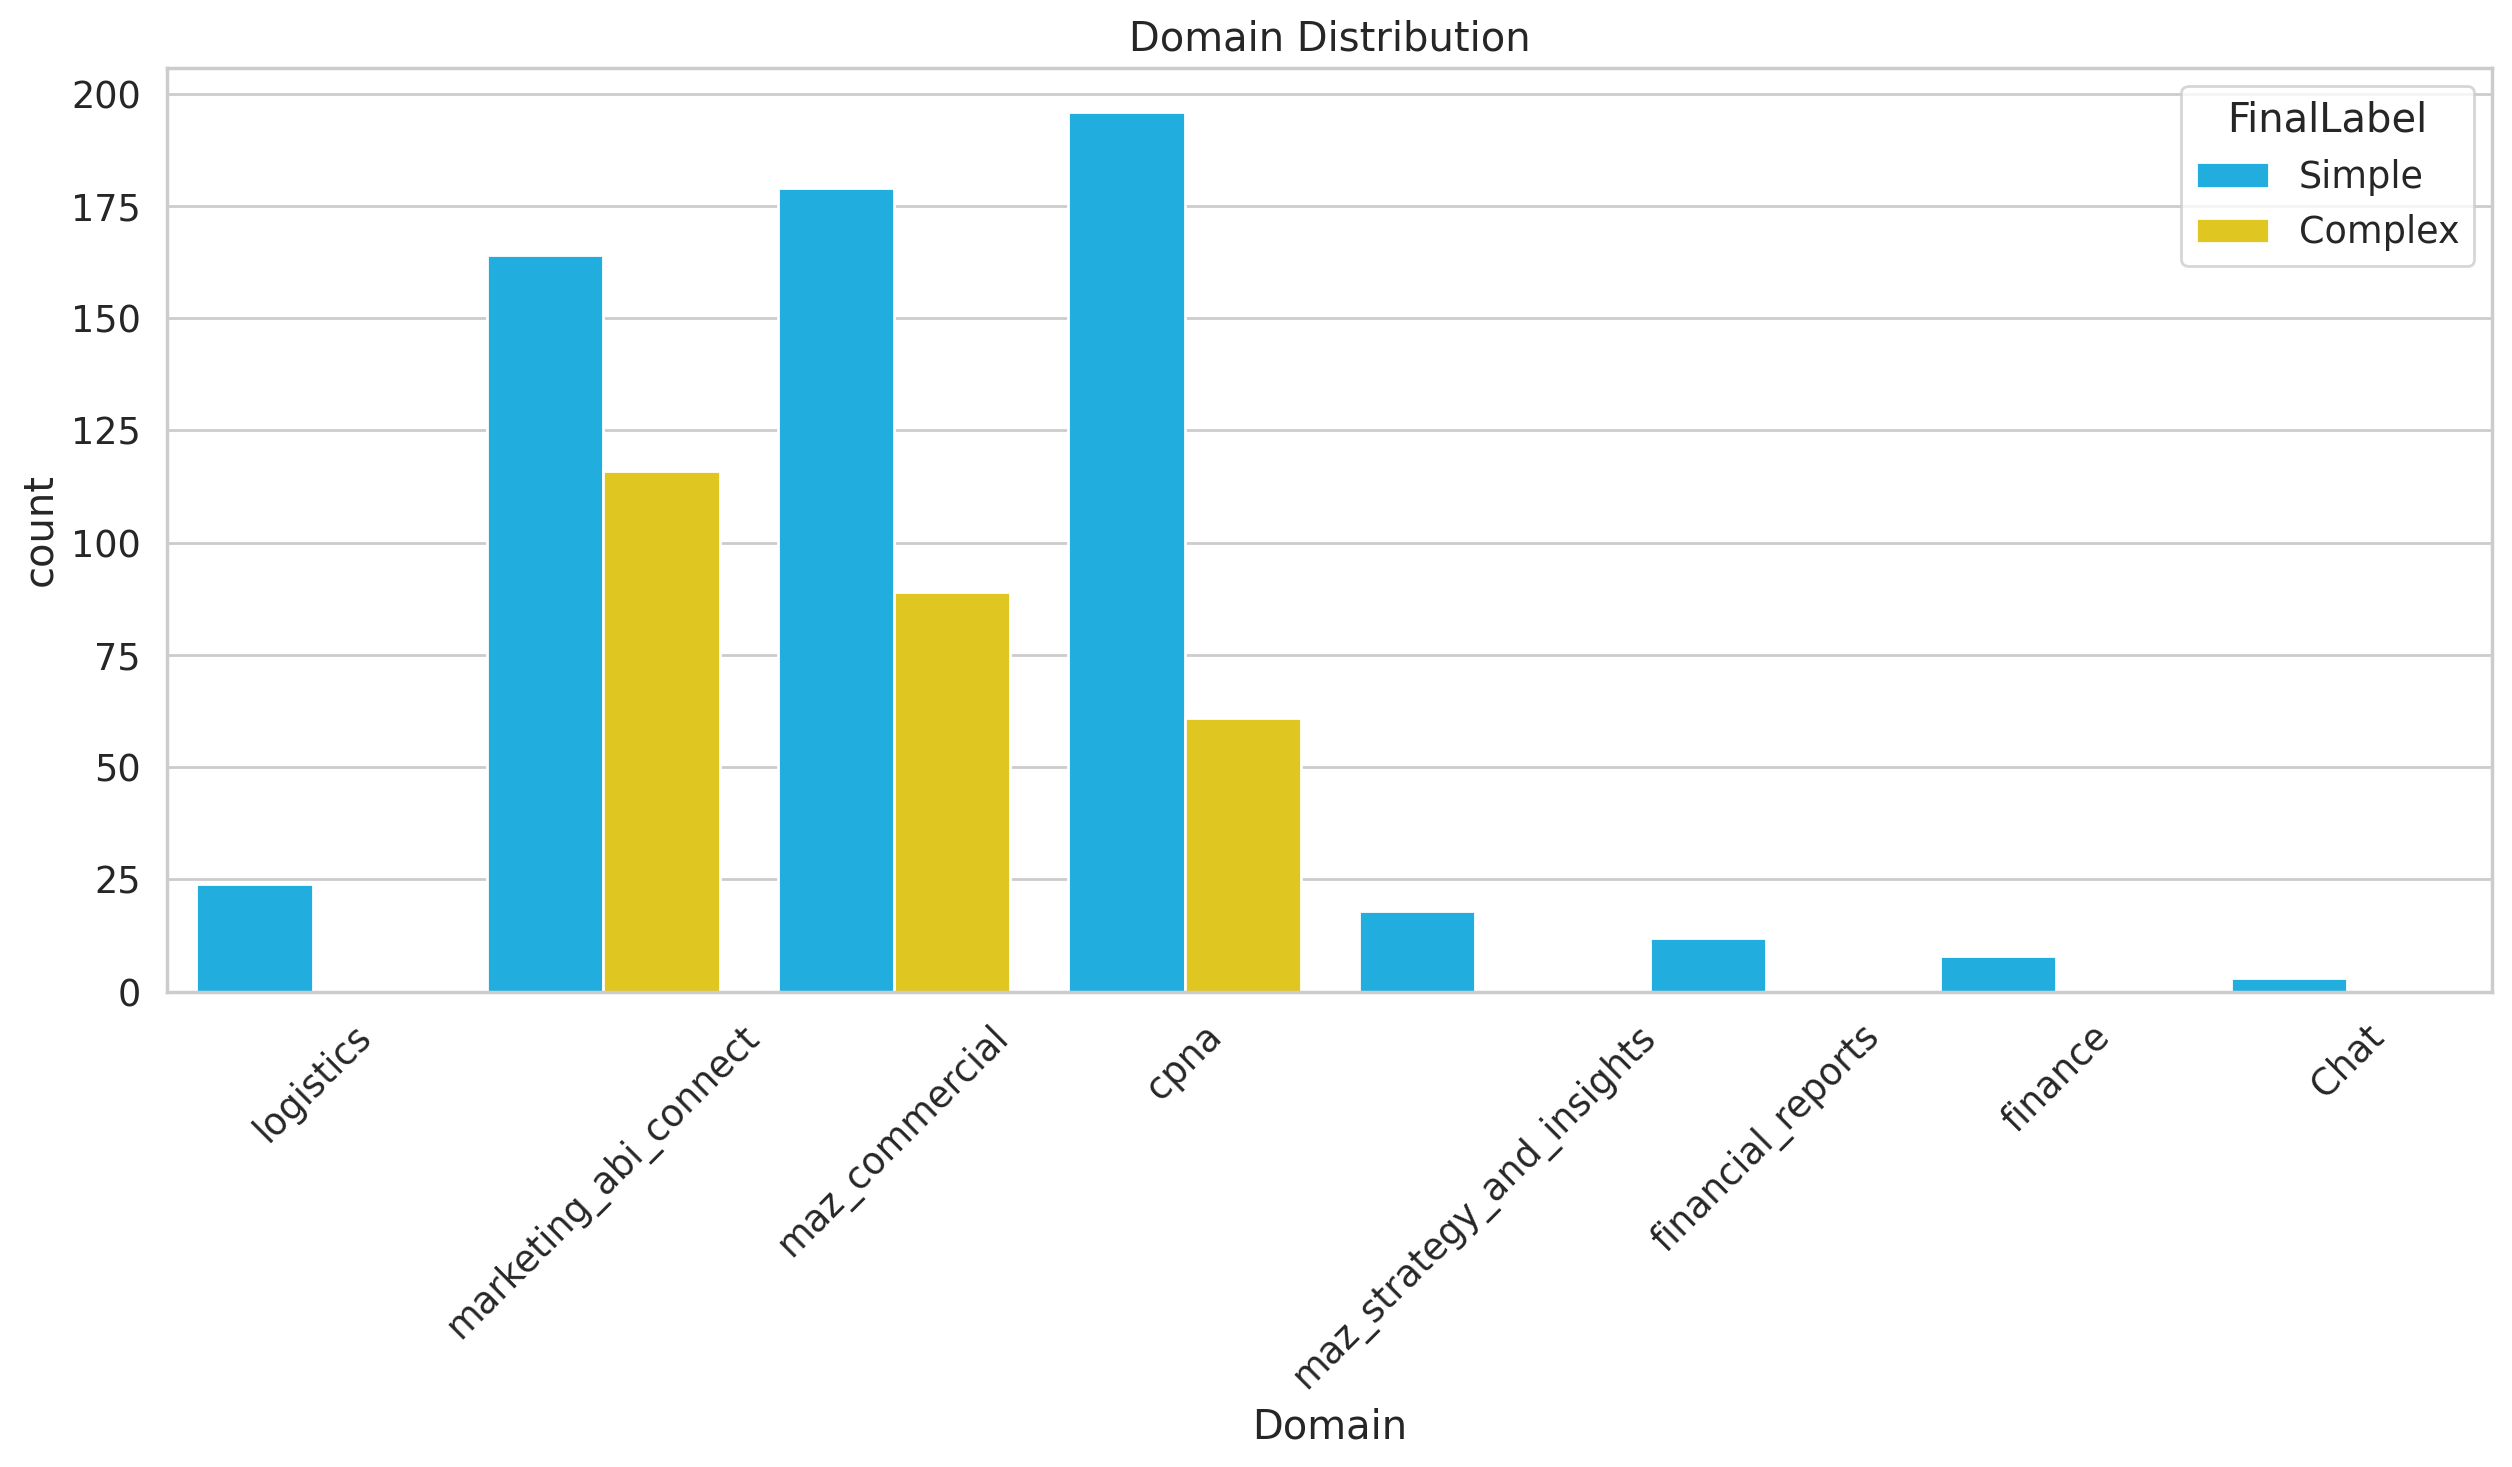

In [10]:
plt.figure(figsize=(15, 6))
sns.countplot(data=final_df, x='Domain', hue='FinalLabel')
plt.xticks(rotation=45)
plt.title('Domain Distribution')
plt.show()

In [11]:
final_df["FinalLabel"].value_counts()

Simple     604
Complex    266
Name: FinalLabel, dtype: int64

In [12]:
final_df.isnull().sum()

Domain        0
Question      0
FinalLabel    0
dtype: int64

In [13]:
final_df["FinalLabel"] = final_df["FinalLabel"].apply(lambda x: x.upper()).map({"SIMPLE":0,"COMPLEX":1})
final_df["FinalLabel"] = final_df["FinalLabel"].astype(int)

In [14]:
final_df.head()

,Domain,Question,FinalLabel
0,logistics,What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?,0
1,logistics,what should beThe target average time in route (Depot to Depot),0
2,marketing_abi_connect,Which social media platform has the highest number of negative sentiments followed by male population for the above brands?,0
3,logistics,What Are Tools And Equipment Used In Truck Departure Process?,0
4,maz_commercial,"What is the net revenue per HL in Aug 2023, July 2023 and percentage change from July to Aug for the above brand?",0


In [15]:
# from matplotlib import pyplot as plt
# import seaborn as sns
# final_df.groupby('Domain').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)

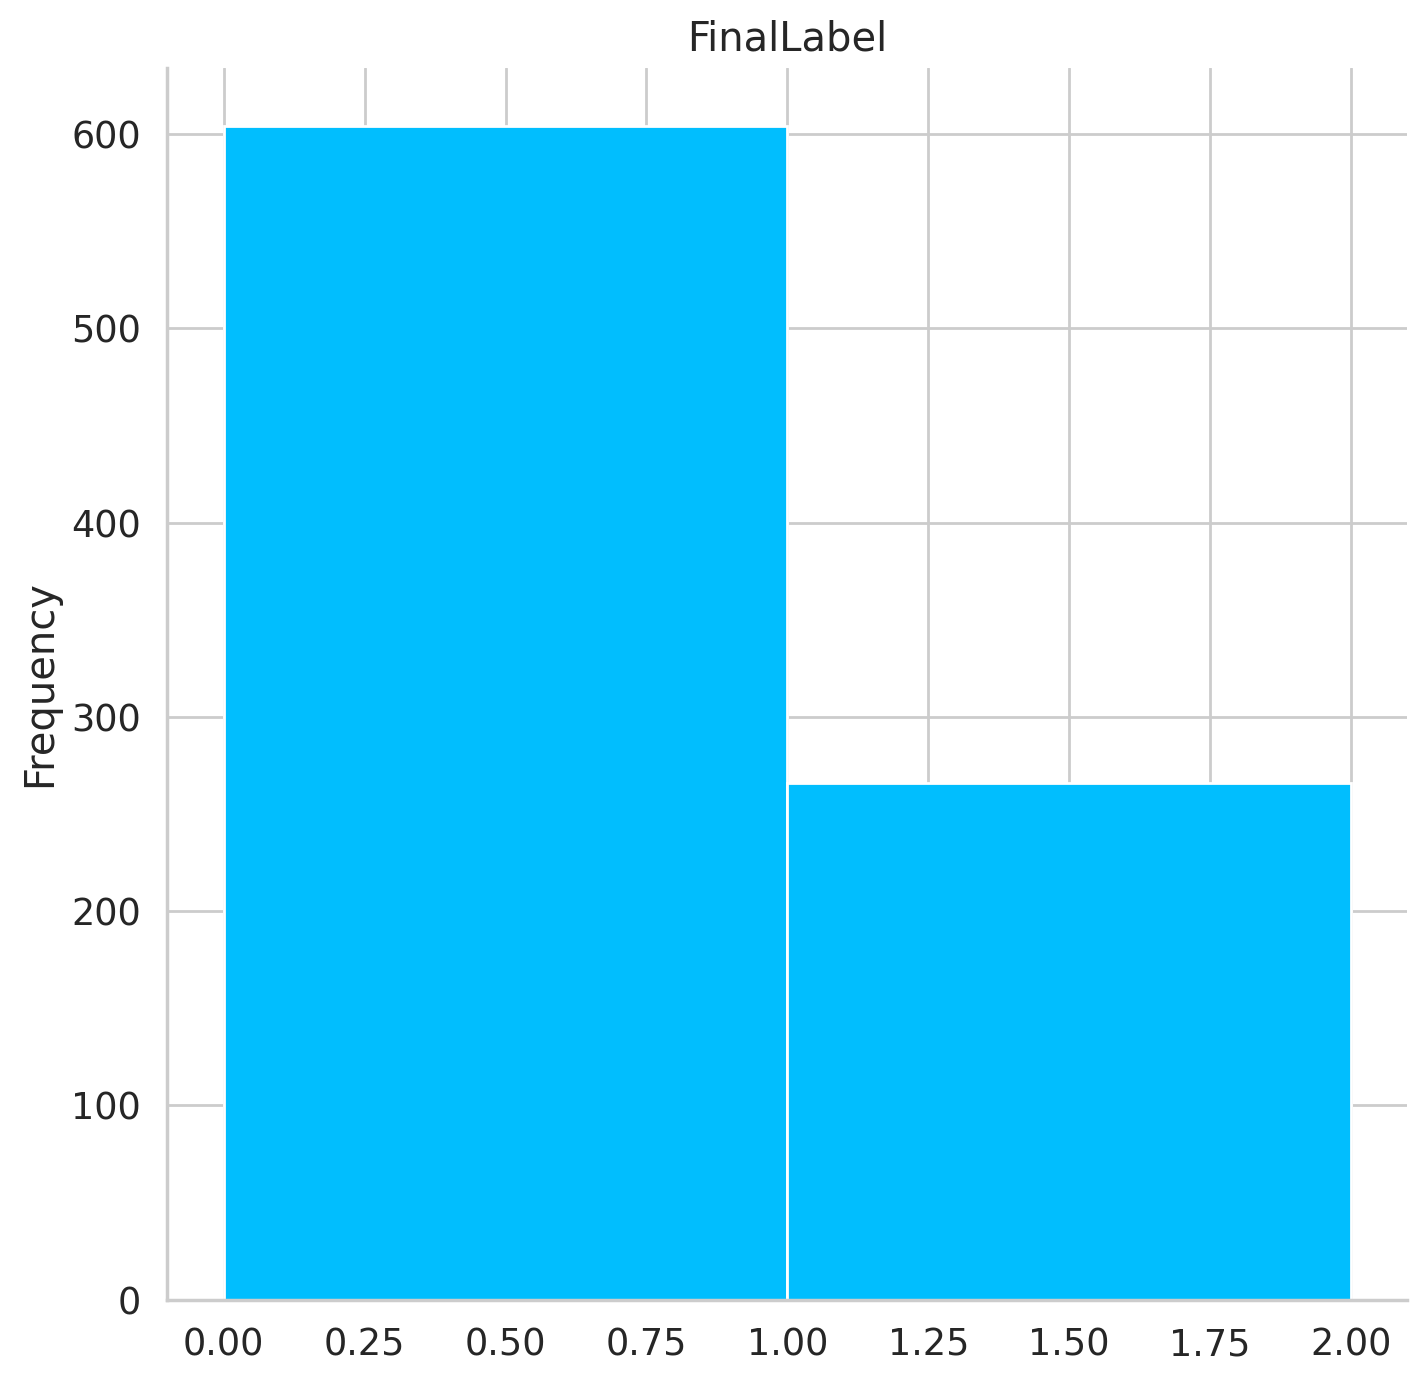

In [16]:
final_df['FinalLabel'].plot(kind='hist', bins=[0,1,2], title='FinalLabel')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
final_df.info(),"Null values",final_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Domain      870 non-null    object
 1   Question    870 non-null    object
 2   FinalLabel  870 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 20.5+ KB


(None,
 'Null values',
 Domain        0
 Question      0
 FinalLabel    0
 dtype: int64)

In [18]:
class_names = ['Simple', 'Complex']

In [19]:
final_df['FinalLabel'].value_counts()

0    604
1    266
Name: FinalLabel, dtype: int64

## Data Preprocessing using Bert tokenizer

In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # cased means What is considered different to what ie case sensitive
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 15
learning_rate = 2e-05

In [21]:
sample_text = final_df["Question"].values[0]
print(sample_text)

What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?


We use tokenizer.encode_plus to do the follwing activities
1. Add speacila tokens like CLS[101] SEP[102] PADDING[0] and UNK[100] in the text
2. Tokenize the tokens with int encoding
3. Provide attention mask which confirms actual tokens and paddings

In [22]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [23]:
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=MAX_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True, # in case larger
  return_tensors='pt',  # Return PyTorch tensors
)

print(encoding.keys())

dict_keys(['input_ids', 'attention_mask'])


In [24]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'].shape)
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'].shape)

128
torch.Size([1, 128])
128
torch.Size([1, 128])


1 added dim is the batch size, which we have to remove while we call this within the custom torch dataset creation

## Training and evaluation dataprep

### Custom Pytorch Dataset creation

In [25]:
class QuestionClassficationDataset(Dataset):

  def __init__(self, question, targets, tokenizer, max_len):
    self.question = question
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.question)

  def __getitem__(self, item):
    review = str(self.question[item])
    if self.targets is not None:
      target = self.targets[item]

    # token encoder
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    if self.targets is not None:
      return {
        'review_text': review,
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'].squeeze(),
        'targets': torch.tensor(target, dtype=torch.float)
      }

    else:

      return {
        'review_text': review,
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'],
      }



In [26]:
sample_dataset = QuestionClassficationDataset(
  question=[final_df["Question"].values[0]],
  targets=[final_df["FinalLabel"].values[0]],
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

In [27]:
for ds in sample_dataset:
  print(ds.keys())

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [28]:
next(iter(sample_dataset))

{'review_text': 'What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?',
 'input_ids': tensor([  101,  1327,  1110,  1103,  6556,  1849,  1107,  3884,  1111,  1269,
          4097,  1118,  1472,  4001,  1107,  1360, 17881,  1495,  1112,  3402,
          2166,  2370,   136,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,  

In [29]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle):
  dataset = QuestionClassficationDataset(
    question=df["Question"].values,
    targets=df["FinalLabel"].values,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle
  )

In [30]:
# startified train test split
train_df , test_df = train_test_split(final_df, test_size=0.25, random_state=42, stratify=final_df["FinalLabel"])
print(train_df.shape)
print(test_df.shape)

(652, 3)
(218, 3)


In [31]:
print(train_df["FinalLabel"].value_counts()/len(train_df))
print(test_df["FinalLabel"].value_counts()/len(test_df))

0    0.694785
1    0.305215
Name: FinalLabel, dtype: float64
0    0.692661
1    0.307339
Name: FinalLabel, dtype: float64


In [32]:
# train test dataloader
train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, True)
test_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE, False)

In [33]:
# batched of 8 with 128 token size
for sample_data in train_loader:
  print(sample_data.keys())
  print(sample_data["input_ids"].shape)
  print(sample_data["attention_mask"].shape)
  print(sample_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])




In [34]:
for test_data in test_loader:
  print(test_data.keys())
  print(test_data["input_ids"].shape)
  print(test_data["attention_mask"].shape)
  print(test_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])




## Bert Classifier

In [35]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [36]:
bert_model_direct = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [38]:
bert_model_direct

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

The bert model gives you only 1 pooler with same 768 hidden units as input and output passed through a tanh activation function.

The bert_model_direct is a classfier which is build on top of the bert model with a linear classifier layer at the end

In [39]:
sample_data['input_ids'].shape, sample_data['attention_mask'].shape

(torch.Size([8, 128]), torch.Size([8, 128]))

In [40]:
# application
op = bert_model(
  input_ids=sample_data['input_ids'],
  attention_mask=sample_data['attention_mask']
)

In [41]:
op['last_hidden_state'].shape

torch.Size([8, 128, 768])

In [42]:
op['pooler_output'].shape

torch.Size([8, 768])

* representation : 8 sentences with 128 tokens with each having a vector of dim 768
* Bert base has 12 sets of transformers where bert large has a set of 24
* For any downstream task we will use the pooler output

### Model Training

In [43]:
class BertSentimentClassifier(nn.Module):

  def __init__(self, n_classes, dropout = 0.1):
    super(BertSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    model_op = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = model_op['pooler_output']
    output = self.drop(pooled_output)
    return self.classifier(output)

In [44]:
bert_base_classifier = BertSentimentClassifier(1).to(device)
bert_base_classifier

BertSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [45]:
# input_ids=sample_data['input_ids'].to(device)
# attention_mask=sample_data['attention_mask'].to(device)

# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [46]:
# model_op = bert_base_classifier(input_ids, attention_mask)
# print(model_op.squeeze().shape)
# print(sample_data["targets"].shape)

In [47]:
# device_setup-----
# loss
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer
optimizer = AdamW(bert_base_classifier.parameters(), lr=learning_rate, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device = device)

# early stopping
early_stopping = EarlyStopping(patience=3, verbose=True, path="baseline_bert.pt")

In [48]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 scheduler,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for _,data in enumerate(pbar):

    ids = data['input_ids'].to(device)
    mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)

    # print(f"The target shape is {targets.shape}")

    # model output
    outputs = model(ids, mask)
    outputs = outputs.flatten()
    # print(f"The output shape is {outputs.shape}")

    # calc loss
    loss = criterion(outputs, targets)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    # gradient clipping -- prevent gradient explosion
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # improvement steps
    optimizer.step() # optimizer step -> minima
    if scheduler is not None:
      scheduler.step() # scheduler step -> lr scheduling

    # metric calc
    metric.update(outputs,targets)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [49]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for _, data in enumerate(pbar, 0):
      ids = data['input_ids'].to(device)
      mask = data['attention_mask'].to(device)
      targets = data['targets'].to(device)

      # print(f"The target shape is {targets.shape}")

      # model output
      outputs = model(ids, mask)
      outputs = outputs.flatten()

      # print(f"The output shape is {outputs.shape}")

     # calc loss
      loss = criterion(outputs, targets)
      test_loss += loss.item()

      # metric calc
      metric.update(outputs, targets)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [50]:
%%time

train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_losses, train_metrics = train_module(
      model = bert_base_classifier,
      device = device,
      train_dataloader = train_loader,
      optimizer = optimizer,
      criterion = criterion,
      metric = metric,
      scheduler = scheduler,
      train_losses = train_losses,
      train_metrics = train_metrics,
  )

  test_losses, test_metrics = test_module(
      model = bert_base_classifier,
      device = device,
      test_dataloader = test_loader,
      criterion = criterion,
      metric = metric,
      test_losses = test_losses,
      test_metrics = test_metrics,
  )

  print(f"The learing rate is {scheduler.get_last_lr()}")

  early_stopping(test_losses[-1], bert_base_classifier, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 1/15
----------


Avg Train Loss: 0.43674211940023955 Avg Train Metric: 0.3696950673602703: 100%|██████████| 82/82 [00:18<00:00,  4.47it/s]
Avg Test Loss: 0.25785964873752426 Avg Test Metric: 0.8110185052667346: 100%|██████████| 28/28 [00:01<00:00, 14.64it/s]


The learing rate is [1.866666666666667e-05]
Validation loss decreased (inf --> 0.257860).  Saving model ...
Epoch 2/15
----------


Avg Train Loss: 0.23046189785094523 Avg Train Metric: 0.8598438813918974: 100%|██████████| 82/82 [00:16<00:00,  4.84it/s]
Avg Test Loss: 0.24611757625825703 Avg Test Metric: 0.9205185132367271: 100%|██████████| 28/28 [00:01<00:00, 16.33it/s]


The learing rate is [1.7333333333333336e-05]
Validation loss decreased (0.257860 --> 0.246118).  Saving model ...
Epoch 3/15
----------


Avg Train Loss: 0.1796474567523635 Avg Train Metric: 0.9054222019707284: 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]
Avg Test Loss: 0.30497905205369796 Avg Test Metric: 0.8936734944581985: 100%|██████████| 28/28 [00:01<00:00, 15.62it/s]


The learing rate is [1.6000000000000003e-05]
EarlyStopping counter: 1 out of 3
Epoch 4/15
----------


Avg Train Loss: 0.14278147893776072 Avg Train Metric: 0.9260044228739854: 100%|██████████| 82/82 [00:17<00:00,  4.79it/s]
Avg Test Loss: 0.17534616114737997 Avg Test Metric: 0.9373861444847924: 100%|██████████| 28/28 [00:01<00:00, 15.69it/s]


The learing rate is [1.4666666666666666e-05]
Validation loss decreased (0.246118 --> 0.175346).  Saving model ...
Epoch 5/15
----------


Avg Train Loss: 0.09823518965063935 Avg Train Metric: 0.9583272548710428: 100%|██████████| 82/82 [00:16<00:00,  4.93it/s]
Avg Test Loss: 0.2709334676619619 Avg Test Metric: 0.9108291396072933: 100%|██████████| 28/28 [00:01<00:00, 15.96it/s]


The learing rate is [1.3333333333333333e-05]
EarlyStopping counter: 1 out of 3
Epoch 6/15
----------


Avg Train Loss: 0.08066800480038382 Avg Train Metric: 0.9577463647214378: 100%|██████████| 82/82 [00:16<00:00,  4.87it/s]
Avg Test Loss: 0.29549413137387354 Avg Test Metric: 0.8890034471239362: 100%|██████████| 28/28 [00:01<00:00, 16.25it/s]


The learing rate is [1.2e-05]
EarlyStopping counter: 2 out of 3
Epoch 7/15
----------


Avg Train Loss: 0.07628305432693351 Avg Train Metric: 0.9747250916027441: 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]
Avg Test Loss: 0.3120704822608137 Avg Test Metric: 0.9116878126348767: 100%|██████████| 28/28 [00:01<00:00, 16.04it/s]

The learing rate is [1.0666666666666667e-05]
EarlyStopping counter: 3 out of 3
Early stopping
CPU times: user 1min 34s, sys: 28.2 s, total: 2min 2s
Wall time: 2min 19s


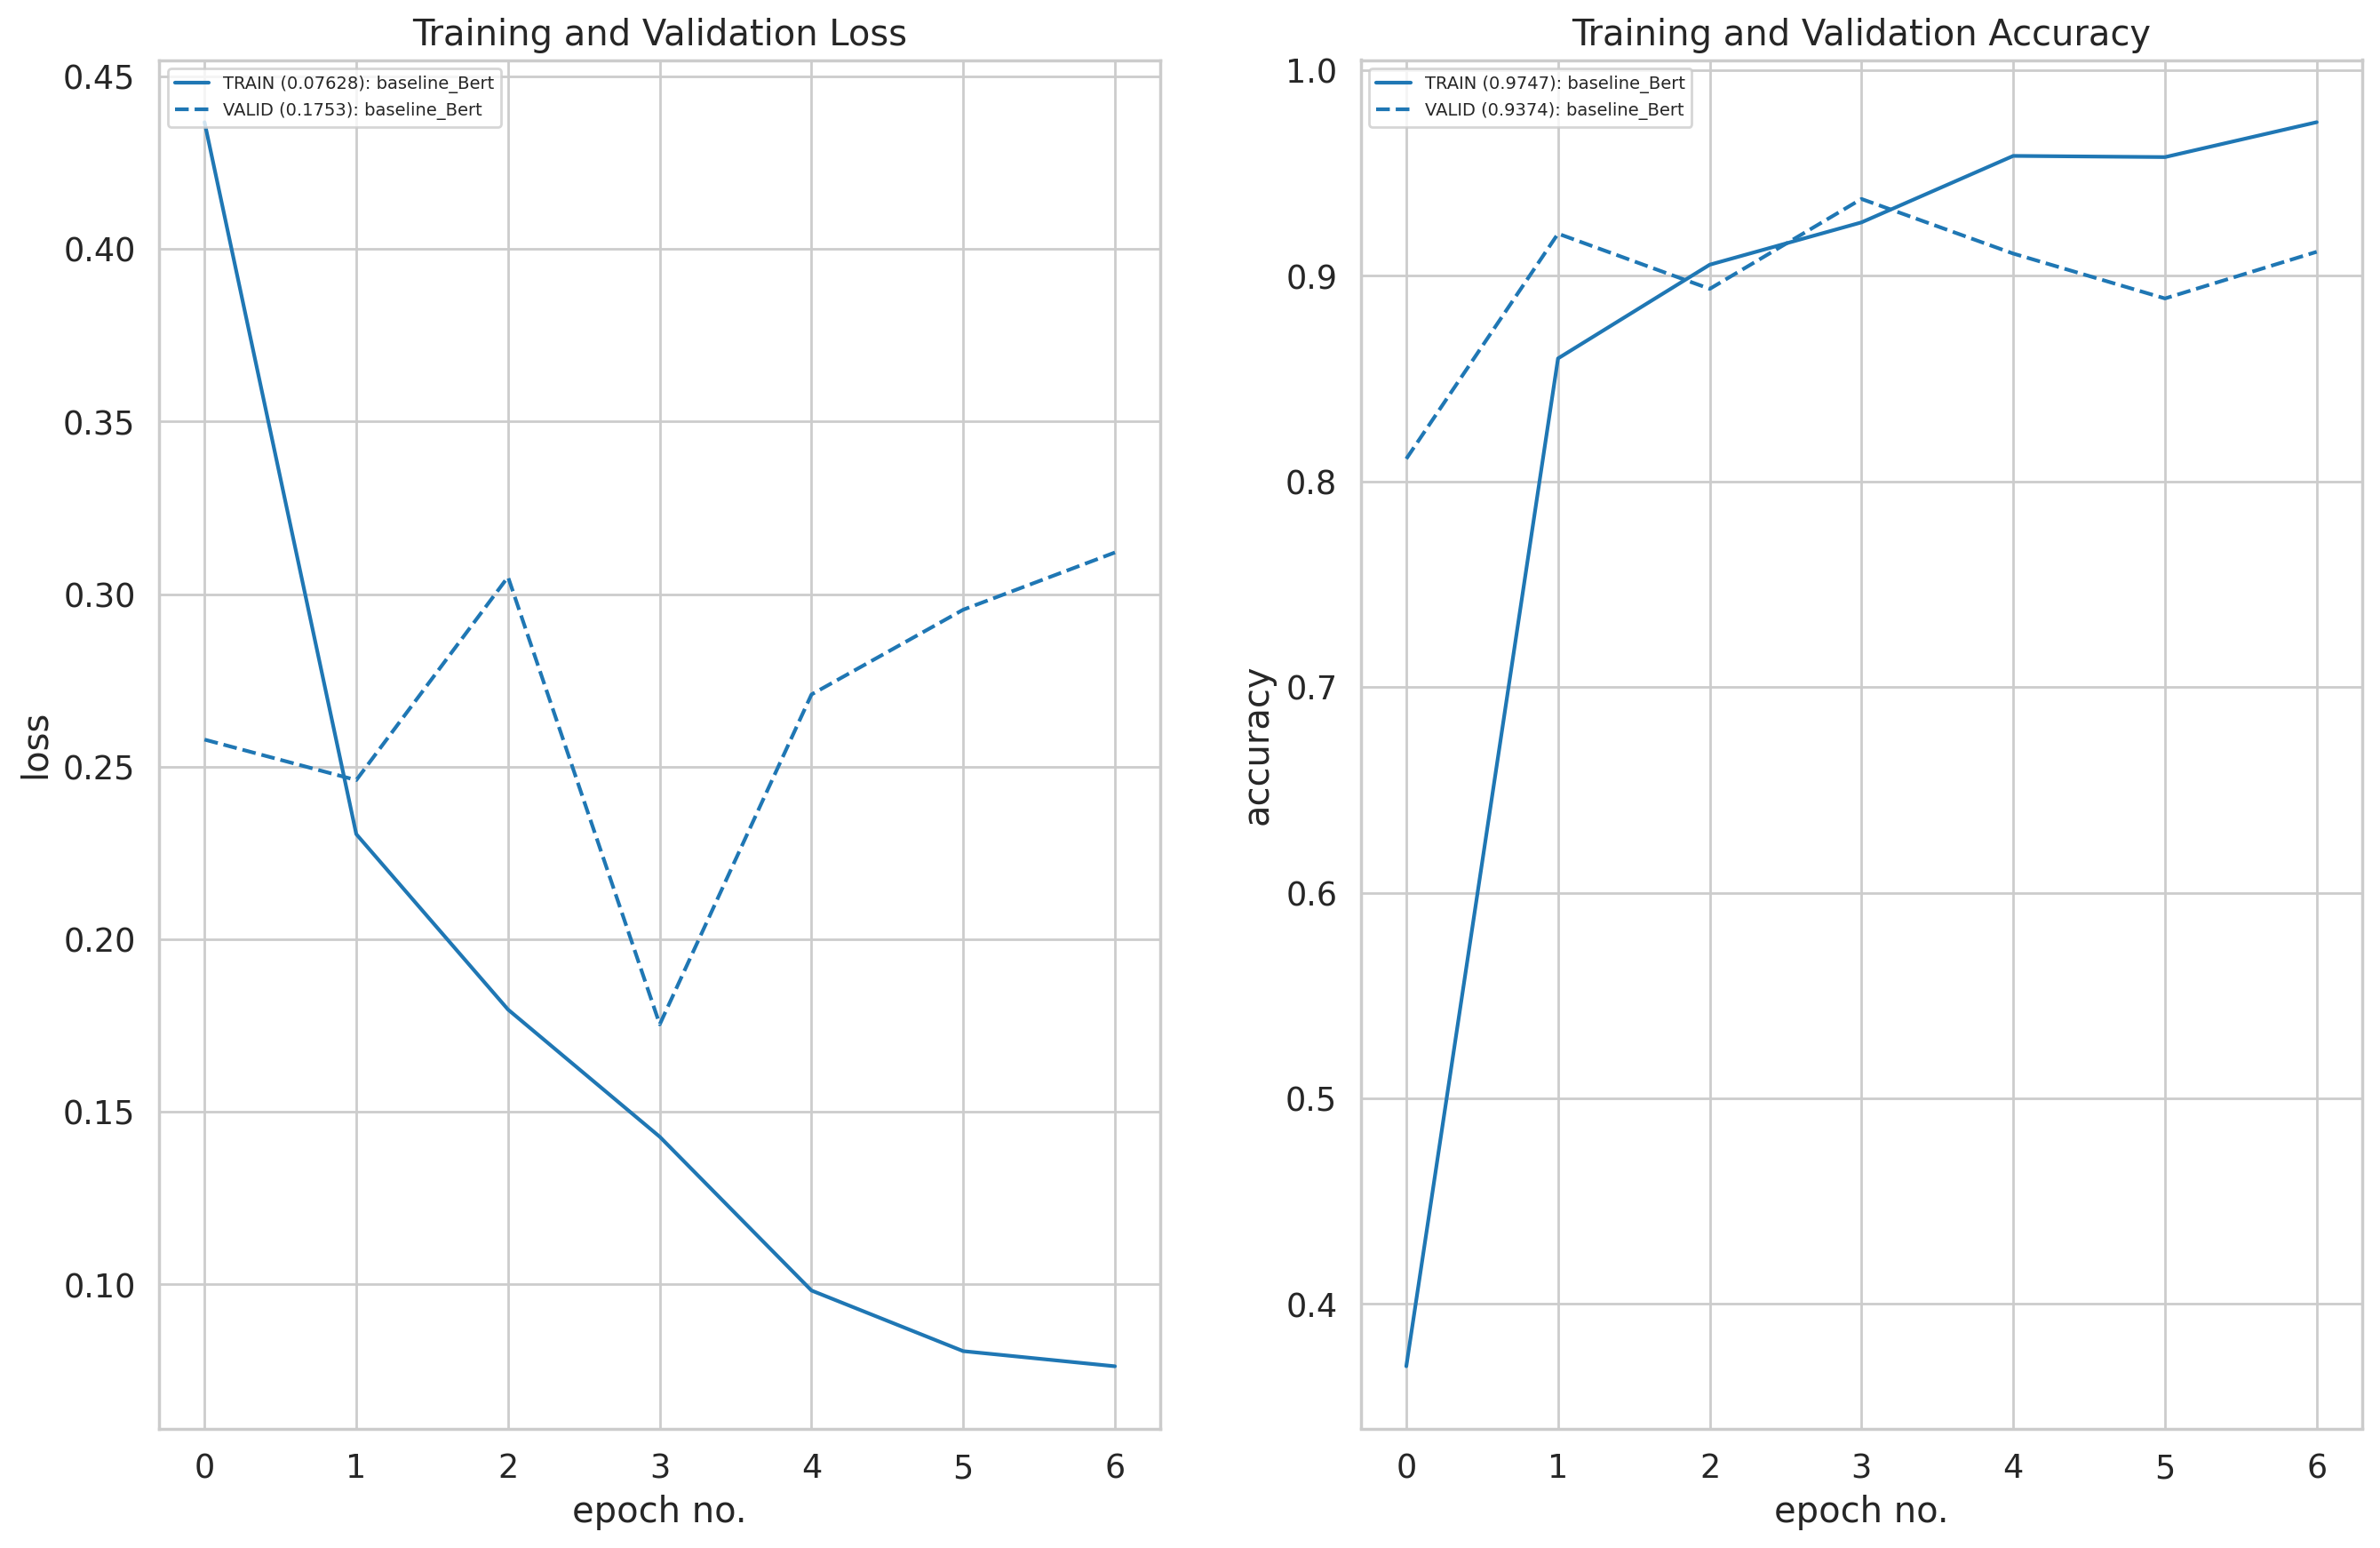

In [51]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline_Bert'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

### Evalutaion Framework

In [52]:
def get_predictions(model, data_loader):

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  model.eval()
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      ).flatten()

      probs = torch.sigmoid(outputs)
      preds = torch.round(probs)


      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()

  return review_texts, predictions, prediction_probs

In [53]:
raw_sentences = ["What was the sales for brand Hurricane in India?",
                 "How did the sales for brand Hurricane changed over last one year?",
                 "Explain how has the impact on water shortage on the production of beer in India?",
                 "How is the performance of Classic lager segment in LP TY compared to LP YA?",
                 "Detail the reasons for drop in sales for brand Corona in the west?",
                 "How did the sales evolved for brand Jupiter over the period of last 6 months?",
                 "Explain in details the reasons for the abrupt changes in sales pattern of Becks in Asian markets?"]

In [54]:
eval_dataset = QuestionClassficationDataset(
  question=raw_sentences,
  targets=None,
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

In [55]:
eval_dataloader = DataLoader(
  eval_dataset,
  batch_size=1,
  shuffle=False
)

In [56]:
review_texts, predictions, prediction_probs = get_predictions(bert_base_classifier , eval_dataloader)

In [57]:
predictions

tensor([0., 0., 1., 1., 1., 0., 1.])

In [58]:
prediction_probs

tensor([0.0032, 0.1991, 0.9994, 0.9990, 0.9996, 0.1732, 0.9996])

## Optimized Classifier

1. Application of Focal loss for unbalanced data
2. application of weights in loss functions
3. A bit more conservative model to tackle overfitting
4. Assure the data to be hetergenous ie use embedding and cosine sim

### Application of a conservative Model

In [59]:
class BertSentimentClassifierExtended(nn.Module):

  def __init__(self, n_classes, fc_hidden = 128 , dropout = 0.1):
    super(BertSentimentClassifierExtended, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.pooler = nn.Linear(self.bert.config.hidden_size, fc_hidden)
    self.bn = nn.BatchNorm1d(fc_hidden)
    self.classifier = nn.Linear(fc_hidden, n_classes)


  def forward(self, input_ids, attention_mask):

    model_op = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = model_op['pooler_output']
    output = self.drop(pooled_output)
    output = self.pooler(output)
    output = self.bn(output)
    return self.classifier(output)

In [60]:
bert_bn_classifier = BertSentimentClassifierExtended(1, 128, 0.1).to(device)
bert_bn_classifier

BertSentimentClassifierExtended(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [61]:
# device_setup-----
# loss
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer
optimizer = AdamW(bert_bn_classifier.parameters(), lr=learning_rate, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device = device)

# early stopping
early_stopping = EarlyStopping(patience=3, verbose=True, path = "extended_bert.pt")

In [62]:
%%time

train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_losses, train_metrics = train_module(
      model = bert_bn_classifier,
      device = device,
      train_dataloader = train_loader,
      optimizer = optimizer,
      criterion = criterion,
      metric = metric,
      scheduler = scheduler,
      train_losses = train_losses,
      train_metrics = train_metrics,
  )

  test_losses, test_metrics = test_module(
      model = bert_bn_classifier,
      device = device,
      test_dataloader = test_loader,
      criterion = criterion,
      metric = metric,
      test_losses = test_losses,
      test_metrics = test_metrics,
  )

  print(f"The learing rate is {scheduler.get_last_lr()}")

  early_stopping(test_losses[-1], bert_bn_classifier, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 1/15
----------


Avg Train Loss: 0.46971497807379176 Avg Train Metric: 0.46498773465069326: 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]
Avg Test Loss: 0.33383655711077154 Avg Test Metric: 0.9050327496869224: 100%|██████████| 28/28 [00:01<00:00, 15.95it/s]


The learing rate is [1.866666666666667e-05]
Validation loss decreased (inf --> 0.333837).  Saving model ...
Epoch 2/15
----------


Avg Train Loss: 0.3299968568153861 Avg Train Metric: 0.8511060578067128: 100%|██████████| 82/82 [00:16<00:00,  4.90it/s]
Avg Test Loss: 0.3217183416709304 Avg Test Metric: 0.8427166704620633: 100%|██████████| 28/28 [00:01<00:00, 15.90it/s]


The learing rate is [1.7333333333333336e-05]
Validation loss decreased (0.333837 --> 0.321718).  Saving model ...
Epoch 3/15
----------


Avg Train Loss: 0.2928096382401702 Avg Train Metric: 0.8562458179345945: 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]
Avg Test Loss: 0.2834311229442911 Avg Test Metric: 0.8345643750258854: 100%|██████████| 28/28 [00:01<00:00, 16.06it/s]


The learing rate is [1.6000000000000003e-05]
Validation loss decreased (0.321718 --> 0.283431).  Saving model ...
Epoch 4/15
----------


Avg Train Loss: 0.2640739294598106 Avg Train Metric: 0.8758250743877597: 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]
Avg Test Loss: 0.286963668851448 Avg Test Metric: 0.88845194876194: 100%|██████████| 28/28 [00:01<00:00, 15.84it/s]


The learing rate is [1.4666666666666666e-05]
EarlyStopping counter: 1 out of 3
Epoch 5/15
----------


Avg Train Loss: 0.2049794428663828 Avg Train Metric: 0.8757774648143024: 100%|██████████| 82/82 [00:16<00:00,  4.93it/s]
Avg Test Loss: 0.2520144461055419 Avg Test Metric: 0.9277170151472092: 100%|██████████| 28/28 [00:01<00:00, 15.88it/s]


The learing rate is [1.3333333333333333e-05]
Validation loss decreased (0.283431 --> 0.252014).  Saving model ...
Epoch 6/15
----------


Avg Train Loss: 0.1711979692506536 Avg Train Metric: 0.9290392231650468: 100%|██████████| 82/82 [00:16<00:00,  4.91it/s]
Avg Test Loss: 0.2574787818427597 Avg Test Metric: 0.9196931847504207: 100%|██████████| 28/28 [00:01<00:00, 15.75it/s]


The learing rate is [1.2e-05]
EarlyStopping counter: 1 out of 3
Epoch 7/15
----------


Avg Train Loss: 0.1676063570534674 Avg Train Metric: 0.9725616567018556: 100%|██████████| 82/82 [00:16<00:00,  4.91it/s]
Avg Test Loss: 0.23230917252866284 Avg Test Metric: 0.9501382453101022: 100%|██████████| 28/28 [00:01<00:00, 15.90it/s]


The learing rate is [1.0666666666666667e-05]
Validation loss decreased (0.252014 --> 0.232309).  Saving model ...
Epoch 8/15
----------


Avg Train Loss: 0.13279961407320892 Avg Train Metric: 0.9758310114465109: 100%|██████████| 82/82 [00:16<00:00,  4.90it/s]
Avg Test Loss: 0.30546629295817446 Avg Test Metric: 0.9079032838344574: 100%|██████████| 28/28 [00:01<00:00, 15.69it/s]


The learing rate is [9.333333333333334e-06]
EarlyStopping counter: 1 out of 3
Epoch 9/15
----------


  0%|          | 0/82 [00:00<?, ?it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.
Avg Train Loss: 0.1403614050827966 Avg Train Metric: 0.9466568471454992: 100%|██████████| 82/82 [00:17<00:00,  4.81it/s]
Avg Test Loss: 0.38025908577921136 Avg Test Metric: 0.9301059522799083: 100%|██████████| 28/28 [00:01<00:00, 15.92it/s]


The learing rate is [8.000000000000001e-06]
EarlyStopping counter: 2 out of 3
Epoch 10/15
----------


Avg Train Loss: 0.12794213664218237 Avg Train Metric: 0.9410018114055075: 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]
Avg Test Loss: 0.27312763397847967 Avg Test Metric: 0.9205704778432846: 100%|██████████| 28/28 [00:01<00:00, 15.99it/s]

The learing rate is [6.666666666666667e-06]
EarlyStopping counter: 3 out of 3
Early stopping
CPU times: user 2min 20s, sys: 46.7 s, total: 3min 6s
Wall time: 3min 18s


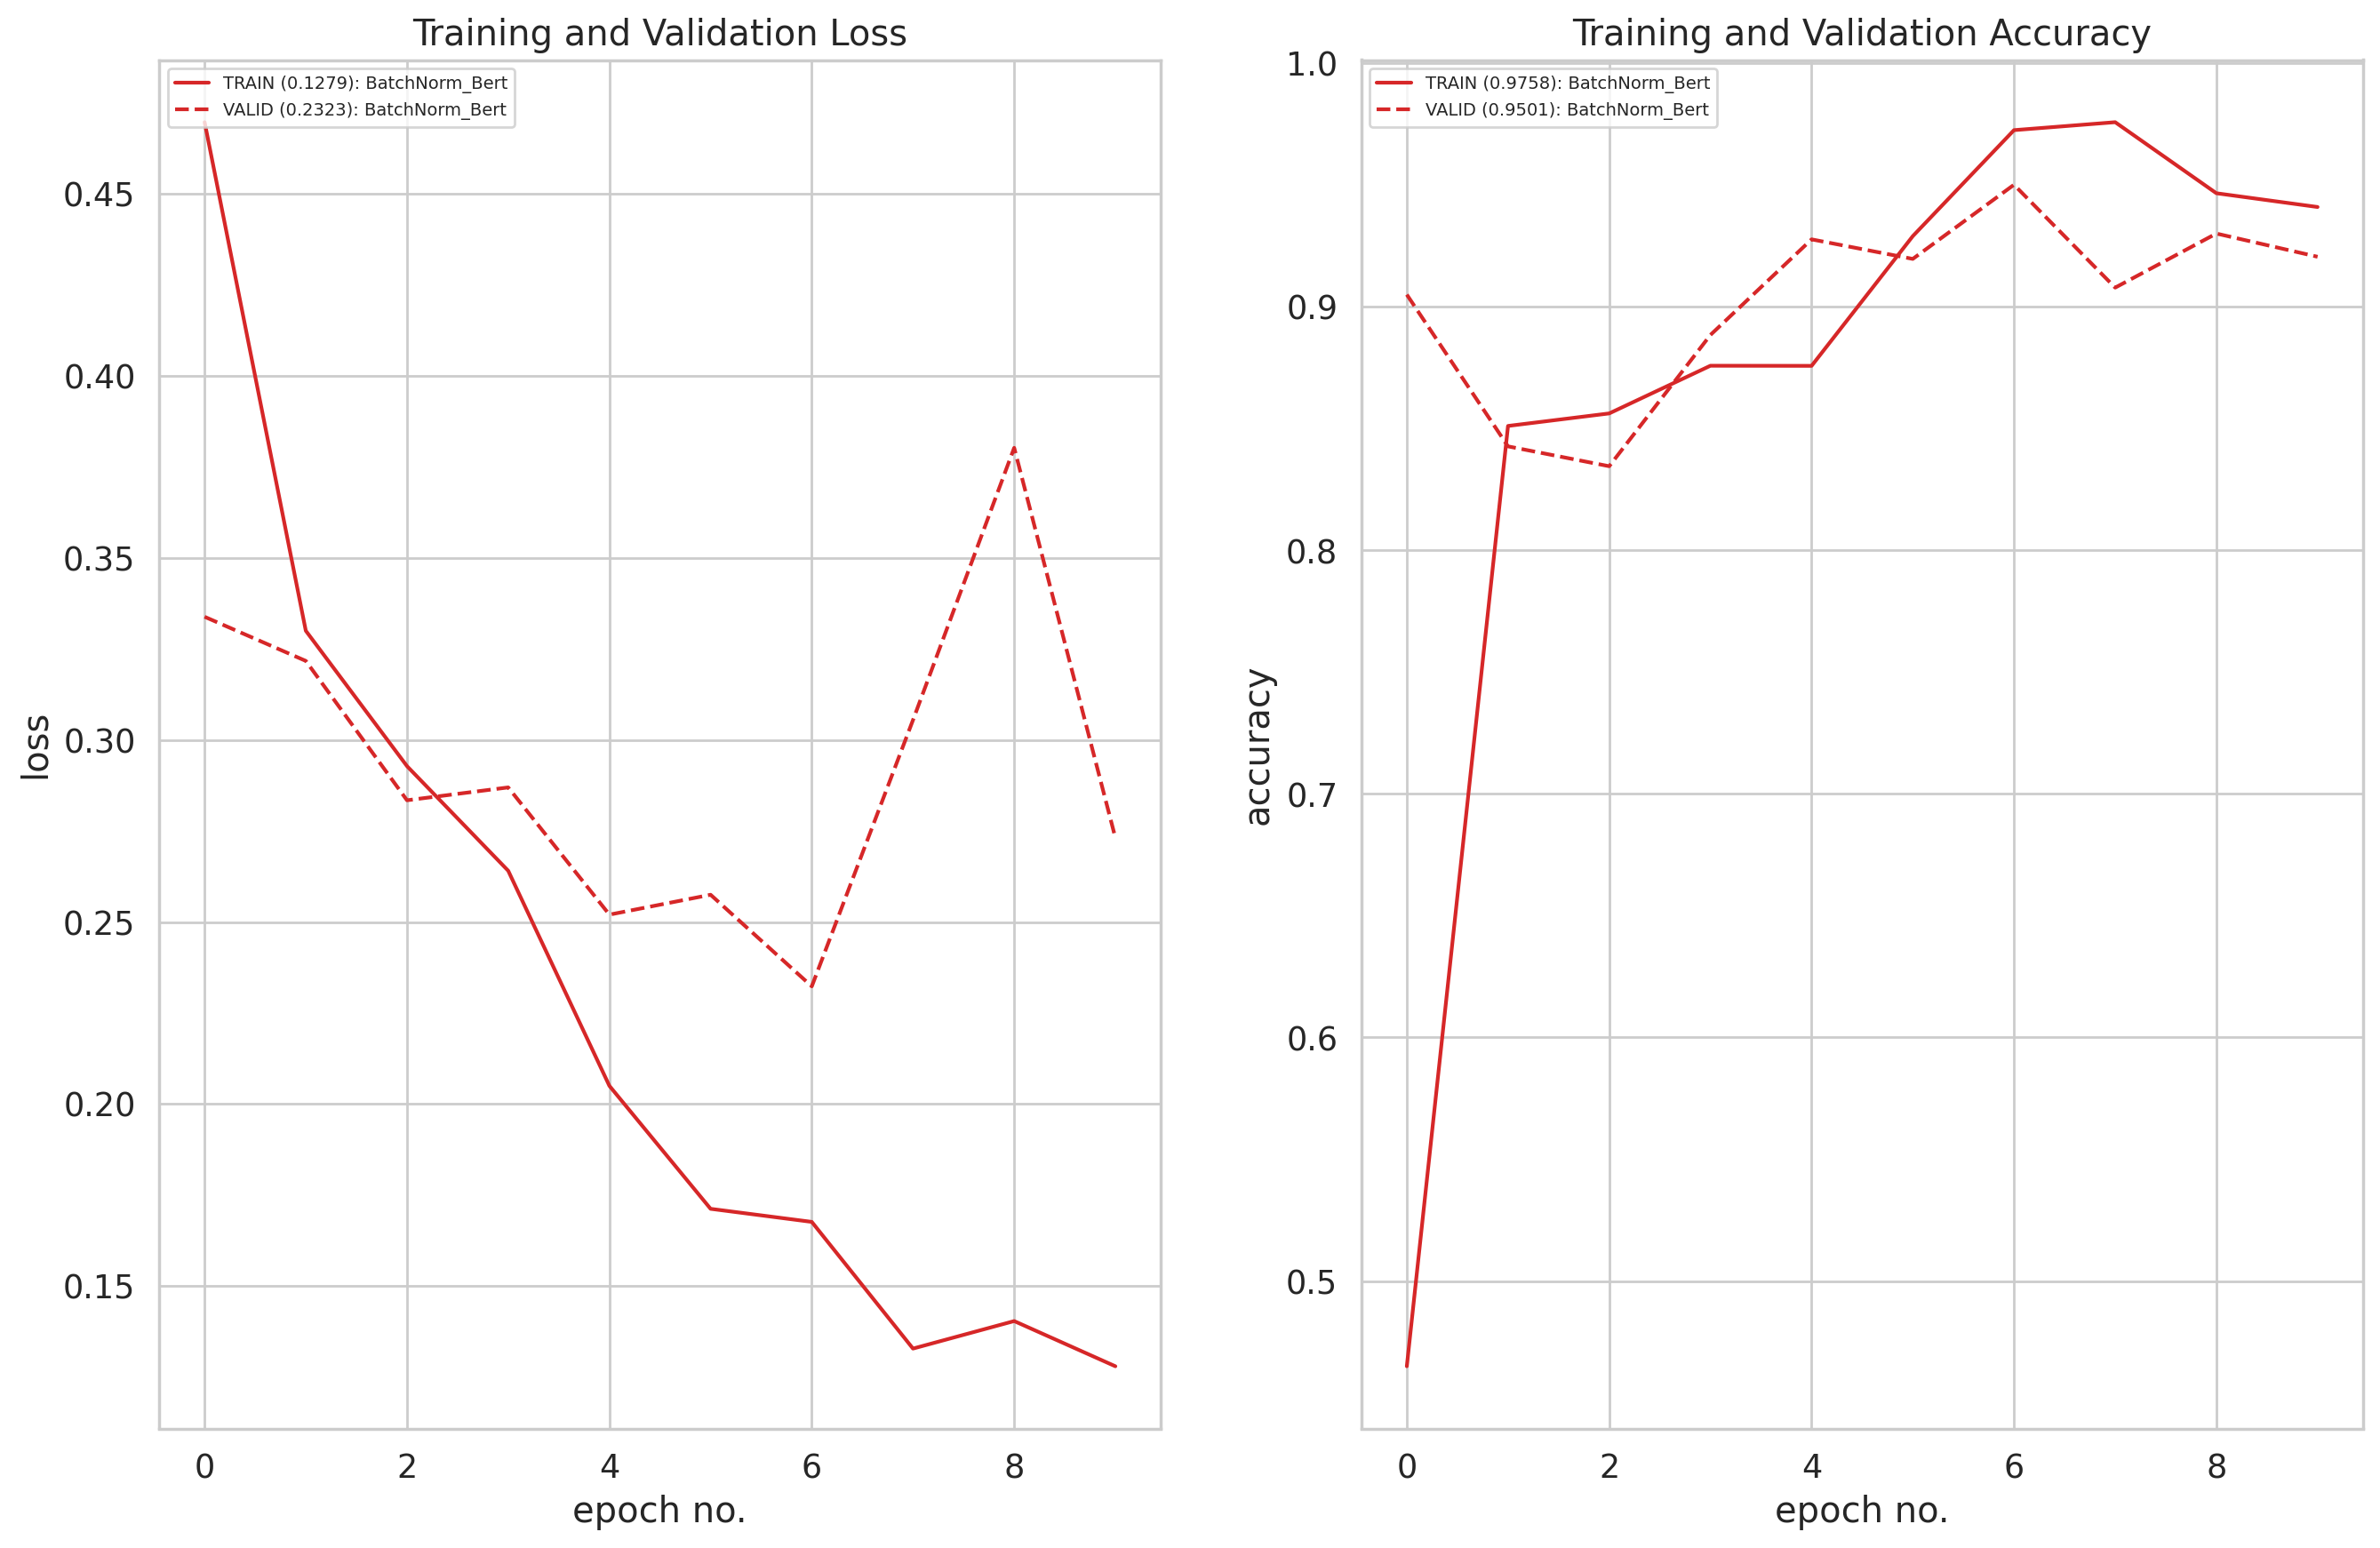

In [63]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BatchNorm_Bert'],
                   colors=['Red'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [64]:
review_texts, predictions, prediction_probs = get_predictions(bert_bn_classifier , eval_dataloader)

In [65]:
predictions

tensor([0., 0., 1., 1., 1., 0., 1.])

In [66]:
prediction_probs

tensor([0.0173, 0.0175, 0.9999, 0.9999, 0.9999, 0.0418, 0.9999])

### Application of weights in loss as per class

In [67]:
def get_train_dataset_pos_weights(train_df,label_columns):
    """Returns weights for positive samples used for unbalanced datasets."""

    num_pos_samples = train_df[label_columns].sum().sum()
    num_neg_samples = len(train_df) - num_pos_samples
    assert len(train_df) == (num_neg_samples + num_pos_samples)
    num_pos_samples_per_label = np.array(
        list(train_df[label_columns].sum()))

    weights = num_neg_samples / (num_pos_samples_per_label + 0.1*(len(train_df)))

    return torch.from_numpy(weights).to(device)

In [68]:
pos_weights = get_train_dataset_pos_weights(train_df,label_columns = ["FinalLabel"])
print(pos_weights)

tensor([1.7146], device='cuda:0', dtype=torch.float64)


In [69]:
bert_bn_classifier = BertSentimentClassifierExtended(1, 128, 0.1).to(device)
bert_bn_classifier

BertSentimentClassifierExtended(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [70]:
# device_setup-----
# loss
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weights)
# optimizer
optimizer = AdamW(bert_bn_classifier.parameters(), lr=learning_rate, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device = device)

# early stopping
early_stopping = EarlyStopping(patience=3, verbose=True, path = "extended_bert_balanced.pt")

In [71]:
%%time

train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_losses, train_metrics = train_module(
      model = bert_bn_classifier,
      device = device,
      train_dataloader = train_loader,
      optimizer = optimizer,
      criterion = criterion,
      metric = metric,
      scheduler = scheduler,
      train_losses = train_losses,
      train_metrics = train_metrics,
  )

  test_losses, test_metrics = test_module(
      model = bert_bn_classifier,
      device = device,
      test_dataloader = test_loader,
      criterion = criterion,
      metric = metric,
      test_losses = test_losses,
      test_metrics = test_metrics,
  )

  print(f"The learing rate is {scheduler.get_last_lr()}")

  early_stopping(test_losses[-1], bert_bn_classifier, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 1/15
----------


  0%|          | 0/82 [00:00<?, ?it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.
Avg Train Loss: 0.5498965148836737 Avg Train Metric: 0.6058435076620521: 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]
Avg Test Loss: 0.7941759897262922 Avg Test Metric: 0.8355439454317093: 100%|██████████| 28/28 [00:01<00:00, 15.96it/s]


The learing rate is [1.866666666666667e-05]
Validation loss decreased (inf --> 0.794176).  Saving model ...
Epoch 2/15
----------


Avg Train Loss: 0.47227766862275394 Avg Train Metric: 0.8827175723343361: 100%|██████████| 82/82 [00:16<00:00,  4.90it/s]
Avg Test Loss: 0.29270233479993685 Avg Test Metric: 0.921464449592999: 100%|██████████| 28/28 [00:01<00:00, 15.66it/s]


The learing rate is [1.7333333333333336e-05]
Validation loss decreased (0.794176 --> 0.292702).  Saving model ...
Epoch 3/15
----------


Avg Train Loss: 0.27203898231794194 Avg Train Metric: 0.9188541879014271: 100%|██████████| 82/82 [00:17<00:00,  4.81it/s]
Avg Test Loss: 0.3383694871195725 Avg Test Metric: 0.9203637370041439: 100%|██████████| 28/28 [00:01<00:00, 15.80it/s]


The learing rate is [1.6000000000000003e-05]
EarlyStopping counter: 1 out of 3
Epoch 4/15
----------


Avg Train Loss: 0.24041185611518237 Avg Train Metric: 0.9298350949112962: 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]
Avg Test Loss: 0.5064176425969761 Avg Test Metric: 0.8769889622926712: 100%|██████████| 28/28 [00:01<00:00, 15.89it/s]


The learing rate is [1.4666666666666666e-05]
EarlyStopping counter: 2 out of 3
Epoch 5/15
----------


Avg Train Loss: 0.20688916625250586 Avg Train Metric: 0.9553698083249534: 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]
Avg Test Loss: 0.3379261577834508 Avg Test Metric: 0.9141836102519717: 100%|██████████| 28/28 [00:01<00:00, 15.92it/s]

The learing rate is [1.3333333333333333e-05]
EarlyStopping counter: 3 out of 3
Early stopping
CPU times: user 1min 9s, sys: 23.3 s, total: 1min 33s
Wall time: 1min 40s


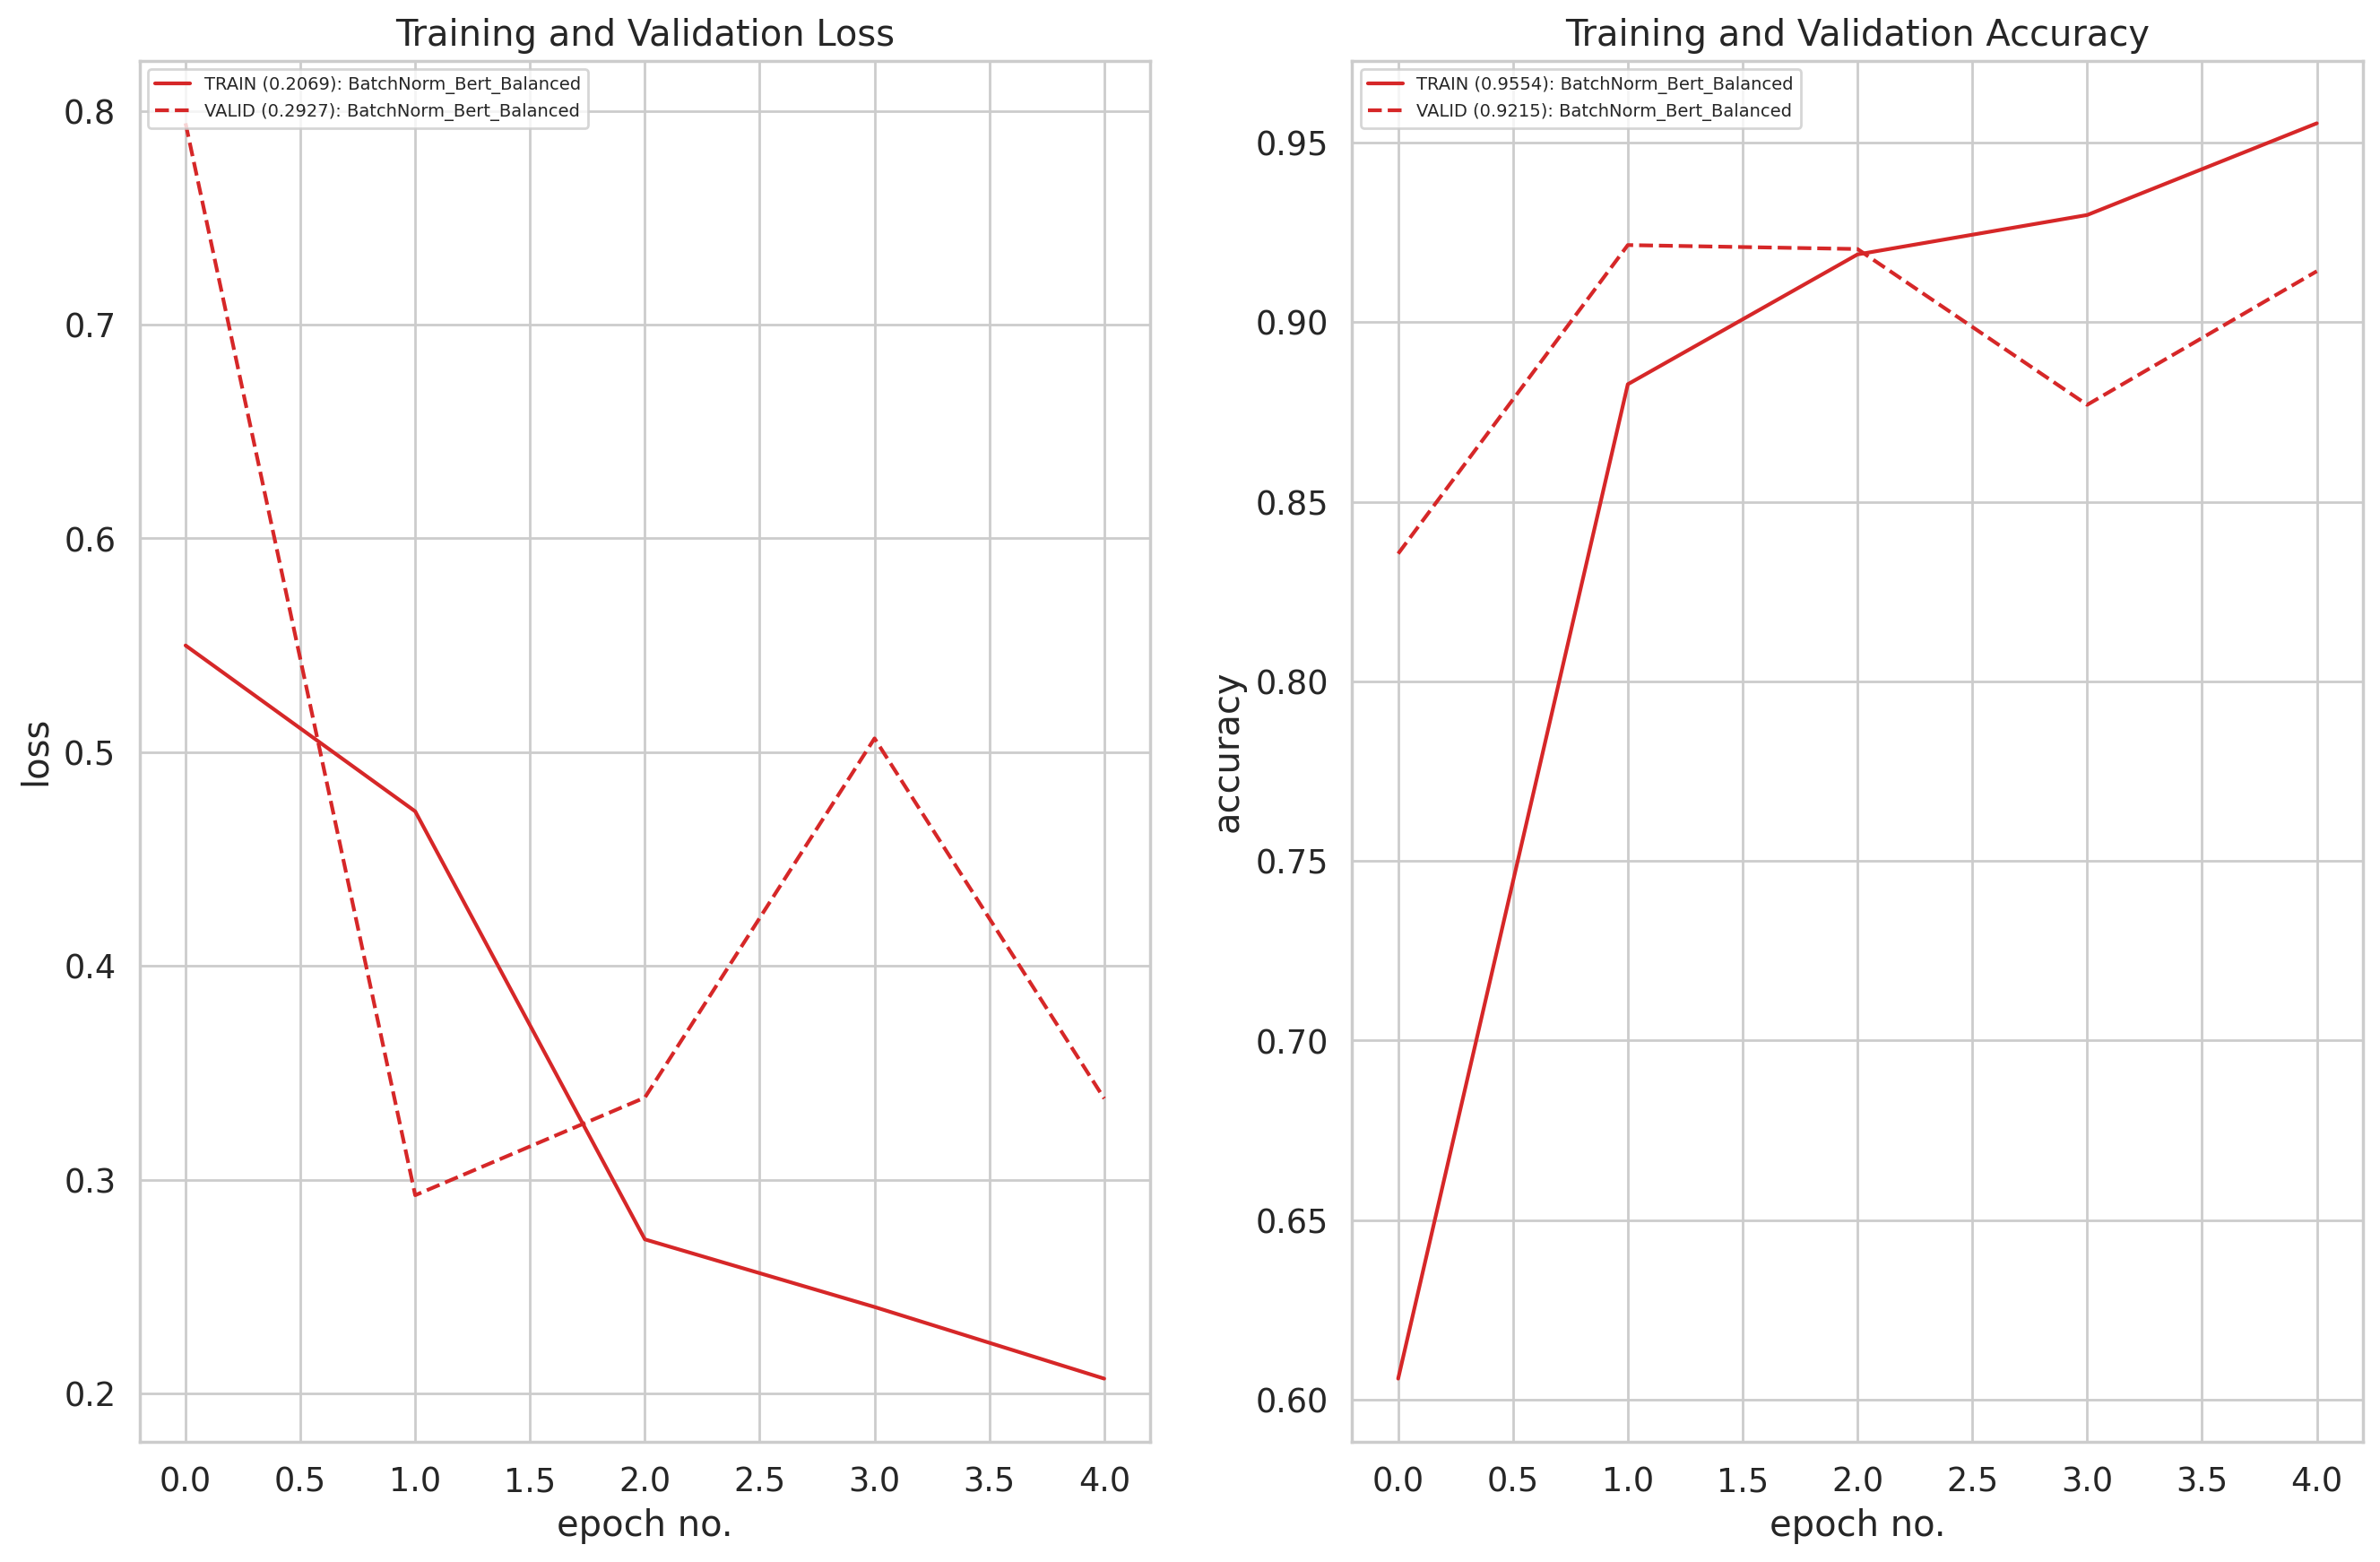

In [72]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BatchNorm_Bert_Balanced'],
                   colors=['Red'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [73]:
review_texts, predictions, prediction_probs = get_predictions(bert_bn_classifier , eval_dataloader)

In [74]:
predictions

tensor([0., 0., 1., 1., 1., 1., 1.])

In [75]:
prediction_probs

tensor([0.0183, 0.1237, 0.9997, 0.9962, 0.9998, 0.8960, 0.9998])

### Application of Focal Loss

In [80]:
class_counts = np.bincount(train_df['FinalLabel'])
num_classes = len(class_counts)
total_samples = len(train_df['FinalLabel'])

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

class_weights = torch.tensor(class_weights).to(device)

In [87]:
bert_bn_classifier = BertSentimentClassifierExtended(1, 128, 0.1).to(device)
bert_bn_classifier

BertSentimentClassifierExtended(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [98]:
class FocalLoss(nn.Module):
    '''
    Multi-class Focal Loss
    '''
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        """
        input: [N, C], float32
        target: [N, ], int64
        """
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

In [100]:
# device_setup-----
# loss
# criterion = torch.hub.load(
# 	'adeelh/pytorch-multi-class-focal-loss',
# 	model='focal_loss',
# 	alpha=class_weights,
# 	gamma=2,
# 	reduction='mean',
# 	device=device,
# 	dtype=torch.float32,
# 	force_reload=False
# )
criterion = FocalLoss(gamma=2, alpha=class_weights)
# optimizer
optimizer = AdamW(bert_bn_classifier.parameters(), lr=learning_rate, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device = device)

# early stopping
early_stopping = EarlyStopping(patience=3, verbose=True, path = "extended_bert_focal.pt")

In [102]:
# %%time

# train_losses = []
# train_metrics = []
# test_losses = []
# test_metrics = []

# for epoch in range(EPOCHS):

#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_losses, train_metrics = train_module(
#       model = bert_bn_classifier,
#       device = device,
#       train_dataloader = train_loader,
#       optimizer = optimizer,
#       criterion = criterion,
#       metric = metric,
#       scheduler = scheduler,
#       train_losses = train_losses,
#       train_metrics = train_metrics,
#   )

#   test_losses, test_metrics = test_module(
#       model = bert_bn_classifier,
#       device = device,
#       test_dataloader = test_loader,
#       criterion = criterion,
#       metric = metric,
#       test_losses = test_losses,
#       test_metrics = test_metrics,
#   )

#   print(f"The learing rate is {scheduler.get_last_lr()}")

#   early_stopping(test_losses[-1], bert_bn_classifier, epoch) # last recorded test loss to measure the improvement against the prior one
#   if early_stopping.early_stop:
#     print("Early stopping")
#     break

** This has to be revisited **

### Measurement of heterogenous nature of the data

We will use SBERT to calcualate sentence embeddings and then calculate the consine similarity between the embeddings.

In [109]:
# embedding careation using sbert
from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

In [139]:
# # Our sentences we like to encode
# sentences = [
#     "The cat sits outside",
#     "A man is playing guitar",
#     "I love pasta",
#     "The new movie is awesome",
#     "The cat plays in the garden",
#     "A woman watches TV",
#     "The new movie is so great",
#     "Do you like pizza?",
# ]

# # Sentences are encoded by calling model.encode()
# embeddings = model.encode(sentences)

# # Print the embeddings
# for sentence, embedding in zip(sentences, embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", len(embedding), type(embedding),embeddings.nbytes,embeddings.dtype)
#     print("")

In [142]:
sentences = final_df['Question'].tolist()
print(len(sentences))

870


In [143]:
## Multiprocess Embedding Generation
# Start the multi-process pool on all available CUDA devices
pool = model.start_multi_process_pool()

# Compute the embeddings using the multi-process pool
emb = model.encode_multi_process(sentences, pool)
print("Embeddings computed. Shape:", emb.shape)

# Optional: Stop the processes in the pool
model.stop_multi_process_pool(pool)

Embeddings computed. Shape: (870, 384)


In [1]:
def calculate_cosine_similarity(vectors):
    """Calculate cosine similarity for list of vectors in n*n fashion."""
    # Convert the list of vectors into a 2D NumPy array
    if isinstance(vectors, list):
        vectors = np.array(vectors)

    # Calculate dot product of vectors with themselves
    dot_products = np.dot(vectors, vectors.T)

    # Calculate norms of vectors
    norms = np.linalg.norm(vectors, axis=1)

    # Calculate outer product of norms to obtain denominator
    norms_outer = np.outer(norms, norms)

    # Avoid division by zero
    norms_outer[norms_outer == 0] = 1e-5

    # Calculate cosine similarity matrix
    similarity_matrix = dot_products / norms_outer

    # Set upper triangular matrix
    similarity_matrix_upper = np.triu(similarity_matrix, k=1)

    return similarity_matrix_upper

In [1]:
cosine_val = calculate_cosine_similarity(emb)

In [ ]:
cosine_vals_ls = [value for value in  cosine_val.flatten().tolist() if value > 0 and value < 1 ]

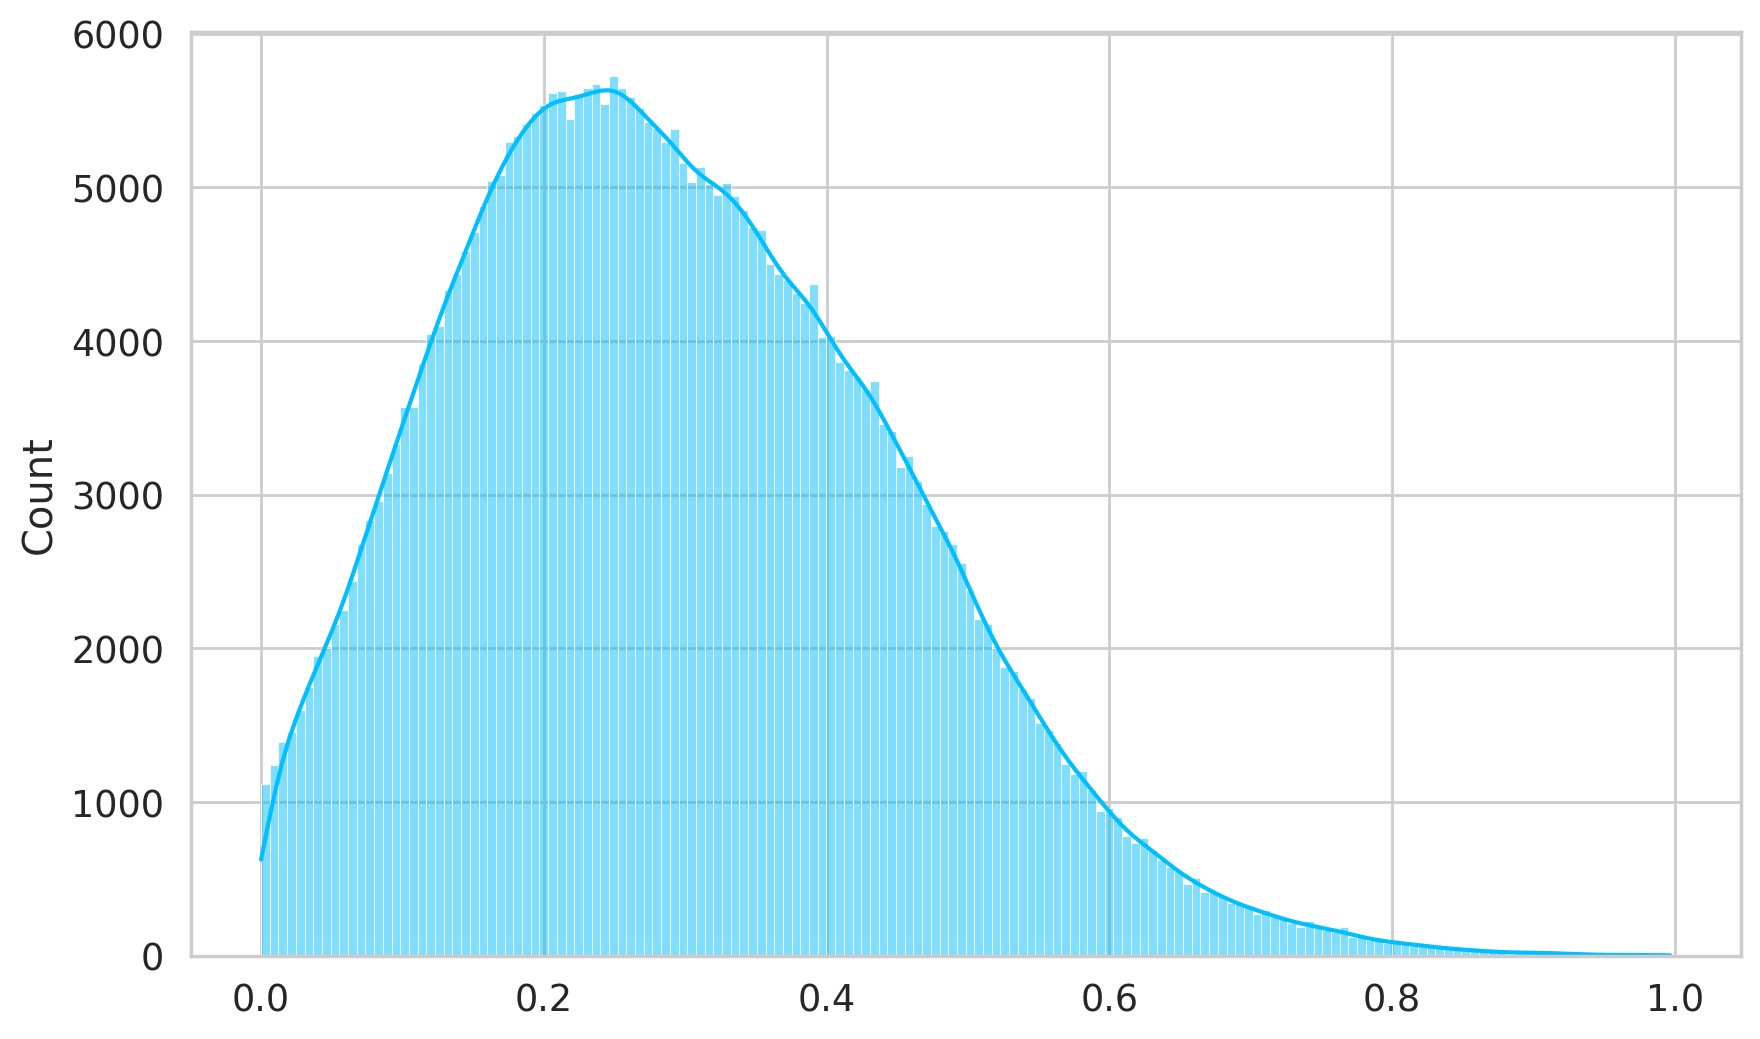

In [156]:
plt.figure(figsize=(10, 6))
# Plot the histogram
sns.histplot(cosine_vals_ls, kde=True)
# Show the plot
plt.show()

In [157]:
np.percentile(cosine_vals_ls,[50,75,90,100])

array([0.28122286, 0.40016864, 0.50483679, 0.99674368])